# Tutorial 2: Mappings, masked channels, and POI models

Masked channels are auxiliary channels that don't enter the fit in the default setup (allthough they might indirectly through more advanced use cases such as regularization). They contain processes with systematic variations as regular channels. This allows to propagate the fitresult into these distributions.

A common use case is a cross section measurement. The cross section is not simply scaling with the signal strength modifier, i.e. $\sigma_\mathrm{measured} \neq \mu \sigma$. Instead, it depends on all systematic uncertainties that change the cross section, usually the theory uncertainties. Masked channels allow to define histograms containing the full dependency of the cross section, i.e. $\sigma_\mathrm{measured} = \sigma(\mu, \vec{\theta})$ where $\vec{\theta}$ are all systematic uncertainties that the cross section depends on. In case a differential cross section measurement is performed, the masked channel contains the generator-level distribution wit all its dependencies.

Mappings are transformations of parameters and observables (histograms). Baseline mappings are 'BaseMapping', 'Project', 'Ratio', or 'AngularCoefficients' but custom mappings can be defined. Any differential function can be implemented as a mapping. Mappings can be applied to regular or masked channels.

## Setting up the environment

Same as before

In [1]:
import os
import sys
from pathlib import Path

# 1. Emulate RABBIT_BASE (points to the 'rabbit' root)
# Since we are in rabbit/notebooks/, we go up one level
rabbit_base = str(Path(os.getcwd()).parent.absolute())
os.environ['RABBIT_BASE'] = rabbit_base

# 2. Update PYTHONPATH so you can 'import rabbit'
if rabbit_base not in sys.path:
    sys.path.append(rabbit_base)
# 2.1 PYTHONPATH also needs to be set to run bash scripts starting with "!"
pythonpath = os.environ.get('PYTHONPATH', '')
if rabbit_base not in pythonpath:
    os.environ['PYTHONPATH'] = rabbit_base + os.pathsep + pythonpath if pythonpath else rabbit_base
    
# 3. Update PATH so you can run scripts from rabbit/bin/
bin_path = os.path.join(rabbit_base, 'bin')
if bin_path not in os.environ['PATH']:
    os.environ['PATH'] = bin_path + os.pathsep + os.environ['PATH']
    
print(f"RABBIT_BASE: {os.environ['RABBIT_BASE']}")
print(f"PATH: {os.environ['PATH']}")

RABBIT_BASE: /home/david/work/Repos/rabbit
PATH: /home/david/work/Repos/rabbit/bin:/home/david/work/Repos/rabbit/env/bin:/home/david/.local/bin:/home/david/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin


In [2]:
from IPython.display import Image, display, IFrame, HTML

## Generating a synthetic toy model

We generate the same model as in the tutorial 1, but now we an additional category axis, this could for example reflect 2 charges, lepton flavors, or any other variable. We also include a masked channel for the cross sections of the signal in these two categories.

In [3]:
import numpy as np
import hist
from wums import boostHistHelpers as hh

axis = hist.axis.Regular(10,0,1, name="x")
axis_cat = hist.axis.Regular(2,-2,2, name="cat", flow=False)

# Create histograms for signal, 2 backhrounds, and data 
h_sig = hist.Hist(axis, axis_cat, storage=hist.storage.Weight())  
h_flat = hist.Hist(axis, axis_cat, storage=hist.storage.Weight())  
h_exp = hist.Hist(axis, axis_cat, storage=hist.storage.Weight())  
h_data = hist.Hist(axis, axis_cat, storage=hist.storage.Double())  
  
# Generate and fill components with weights  
np.random.seed(42)  
# Gaussian signal (mean=0.5, std=0.1) with weights  
sig_samples = np.random.normal(0.5, 0.1, 5000)
sig_cats = np.random.choice([-1, 1], size=5000)
sig_weights = np.random.normal(1.0, 0.2, 5000)  # Mean weight=1, sigma=0.2 
h_sig.fill(sig_samples, sig_cats, weight=sig_weights)  
  
# Flat background with weights  
flat_samples = np.random.uniform(0, 1, 4000)  
flat_cats = np.random.choice([-1, 1], size=4000)
flat_weights = np.random.normal(0.5, 0.1, 4000)  # Mean weight=0.5, sigma=0.1
h_flat.fill(flat_samples, flat_cats, weight=flat_weights)  
  
# Exponential background with weights  
exp_samples = np.random.exponential(0.2, 500)  
exp_cats = np.random.choice([-1, 1], size=500)
exp_weights = np.random.normal(10, 2, 500)  # Mean weight=10, sigma=2 
h_exp.fill(exp_samples, exp_cats, weight=exp_weights)  
  
# Sum components and add Poisson fluctuations
h_data.values()[...] = np.random.poisson(  
    h_sig.values() + h_flat.values() + h_exp.values()  
)

# Generate and 2D Shape Systematics
def make_shape_var(h, factor_func):  
    h_var = h.copy()  
    
    # 1. Calculate the x-dependent weights (1D array)
    centers_x = h.axes[0].centers  
    weights_x = factor_func(centers_x)  
    
    # 2. Create the sign flip for the categories
    # Assuming bin 0 is 'negative' and bin 1 is 'positive'
    # This creates an array: [-1, 1]
    category_signs = np.array([-1, 1])
    
    # 3. Combine them using broadcasting
    # (N, 1) * (1, 2) results in an (N, 2) matrix of weights
    # The first column will be -weights_x, the second will be +weights_x
    total_weights = weights_x[:, np.newaxis] * category_signs[np.newaxis, :]
        
    # 4. Apply to the histogram values
    h_var.values()[...] = h.values() * (1 + total_weights)  
    return h_var

# Variation for flat background
h_flat_up = make_shape_var(h_flat, lambda c: 0.1 * np.exp(2 * (c - 0.5)))  
h_flat_dn = make_shape_var(h_flat, lambda c: -0.08 * np.exp(2 * (c - 0.5)))  

# Variation for signal (slope)
h_sig_up = make_shape_var(h_sig, lambda c: 0.5 * (c - 0.5))  
h_sig_dn = make_shape_var(h_sig, lambda c: -0.5 * (c - 0.5))  

# This represents the cross section histogram with 2 bins in the category axis
#  This could for example be the information at generator leve. 
#  We divide the number of expected events by a hypothetical luminosity and efficiency
lumi = 1000
eff = np.array([0.91, 0.92])
acc = np.array([0.52, 0.78])
scale = 1 / (lumi * eff * acc)

h_sig_xsec = hh.scaleHist(h_sig.project("cat"), scale) 
h_sig_xsec.variances()[...] = 0 # let's asume we have infinite statistics at gen level

h_sig_xsec_up = hh.scaleHist(h_sig_up.project("cat"), scale)
h_sig_xsec_dn = hh.scaleHist(h_sig_dn.project("cat"), scale)

# Input tensor construction
this time we put this in a function to re-use it later.

We are also adding a masked channel with 2 cross section bins that contain the category information.

In [4]:
from rabbit import tensorwriter  
import os

def write_tensor(filename="input", systematic_type="log_normal"):
    # 1. Initialize with the 2D channel
    writer = tensorwriter.TensorWriter(systematic_type=systematic_type)

    # Note: axis and axis_cat were defined in your previous step
    writer.add_channel([axis, axis_cat], name="ch0")

    # 2. Add Data and Processes (using the 2D histograms)
    writer.add_data(h_data, "ch0")  
    writer.add_process(h_flat, "flat_bkg", "ch0", signal=False)  
    writer.add_process(h_exp, "exp_bkg", "ch0", signal=False)  
    writer.add_process(h_sig, "signal", "ch0", signal=True)  

    # 3. Normalization and shape systematics
    writer.add_norm_systematic("lumi", ["signal", "flat_bkg", "exp_bkg"], "ch0", 1.01)
    writer.add_norm_systematic("flat_bkg_norm", "flat_bkg", "ch0", 1.1)

    writer.add_systematic(  
        [h_flat_up, h_flat_dn],  
        "flat_bkg_shape",  
        "flat_bkg",  
        "ch0",  
        symmetrize="linear",
        constrained=True,  
    )  

    writer.add_systematic(  
        [h_sig_up, h_sig_dn],  
        "slope",  
        "signal",  
        "ch0",  
        symmetrize="average",  
        constrained=False,  
    )
                                       
    # 4. adding a masked channel with the corresponding systematic uncertainty
    writer.add_channel([axis_cat], name="ch0_masked", masked=True)
    writer.add_process(h_sig_xsec, "signal", "ch0_masked", signal=True)

    writer.add_systematic(  
        [h_sig_xsec_up, h_sig_xsec_dn],  
        "slope",  
        "signal",  
        "ch0_masked",  
        symmetrize="average",  
        constrained=False,  
    )
    

    directory="results/advanced/"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Write the input tensor to HDF5  
    writer.write(
        outfilename=f"{directory}/{filename}.hdf5"
    )

In [5]:
write_tensor()

/home/david/work/Repos/rabbit/rabbit/tensorwriter.py:459: RuntimeWarning: invalid value encountered in divide
  _logk = kfac * np.log(syst / norm)


## Input data diagnostics

In [6]:
!rabbit_plot_inputdata.py ./results/advanced/input.hdf5 -o ./results/advanced --legCols 1 \
--varName slope --varLabel 'Slope' --varColor red --selectionAxes cat --channels ch0 --titlePos 0

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/advanced/hist_stack_x_ch0_cat0.png?v={v}" style="width: 45%;" />
    <img src="results/advanced/hist_stack_x_ch0_cat1.png?v={v}" style="width: 45%;" />
</div>
"""))


2026-02-27 18:23:09.708000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:23:09.708363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:23:09.760857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:23:11.084363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

# Fit

Now we compute the effect on the masked channel using the mapping functionality:
- -m Select ch0_masked just selects the ch0_masked histogram, 
- -m Project ch0_masked projects the histogram from ch0_masked to a single bin,
- -m Ratio ch0_masked cat:0 cat:1 computes the ratio between the two category bins.

In [31]:
!rabbit_fit.py ./results/advanced/input.hdf5 -t 0 --unblind -o ./results/advanced \
-m Select ch0_masked -m Project ch0_masked -m Ratio ch0_masked ch0_masked cat:0 cat:1 \
--doImpacts --globalImpacts \
--saveHists --saveHistsPerProcess --computeHistErrors --computeHistCov --computeVariations --computeHistImpacts

2026-02-27 18:30:21.292606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:30:21.292944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:30:21.346486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:30:22.734758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Prefit & postfit plots

INFO:rabbit_plot_hists.py: Make plot for Select in channel ch0_masked
INFO:plot_tools.py: Wrote file(s) ./results/advanced//postfit_cat_ch0_masked_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//postfit_cat_ch0_masked_Select.pdf(.png)
INFO:rabbit_plot_hists_uncertainties.py: Make plot for Select in channel ch0_masked
INFO:plot_tools.py: Wrote file(s) ./results/advanced//uncertainties_cat_ch0_masked_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//uncertainties_cat_ch0_masked_Select.pdf(.png)


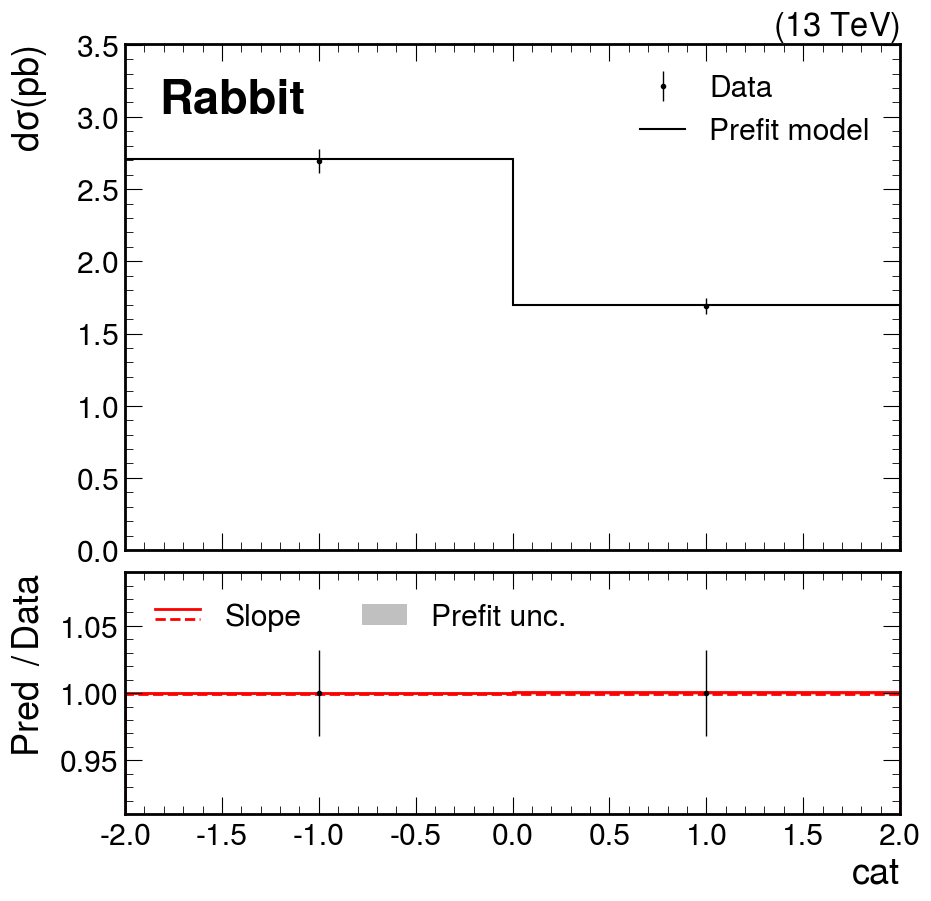

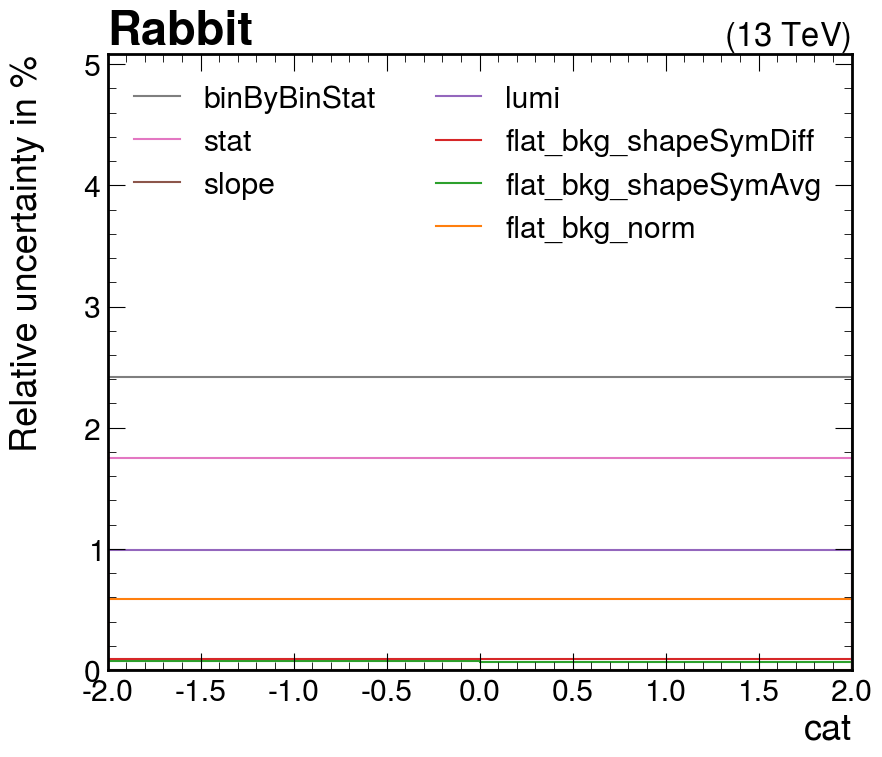

In [8]:
!rabbit_plot_hists.py results/advanced/fitresults.hdf5 -m Select -o ./results/advanced \
 --legCols 1 --rrange 0.91 1.09 --ratioToData --yscale 1.2 --unfoldedXsec \
--varName slope --varLabel 'Slope' --varColor red

!rabbit_plot_hists_uncertainties.py results/advanced/fitresults.hdf5 -m Select -o ./results/advanced \
--yscale 2 --titlePos 0

display(Image(filename='results/advanced/postfit_cat_ch0_masked_Select.png'))
display(Image(filename='results/advanced/uncertainties_cat_ch0_masked_Select.png'))

In [9]:
!rabbit_plot_hists_cov.py results/advanced/fitresults.hdf5 \
-m Select -o ./results/advanced --titlePos 0

!rabbit_plot_hists_cov.py results/advanced/fitresults.hdf5 \
-m Select --correlation -o ./results/advanced --titlePos 0

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/advanced/hist_cov_postfit_Select.png?v={v}" style="width: 45%;" />
    <img src="results/advanced/hist_corr_postfit_Select.png?v={v}" style="width: 45%;" />
</div>
"""))

INFO:plot_tools.py: Wrote file(s) ./results/advanced//hist_cov_postfit_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//hist_cov_postfit_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//hist_corr_postfit_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//hist_corr_postfit_Select.pdf(.png)


### Bin by bin statistics
The uncertainty on the prediction per bin and process is treated following the Barlow--Beeston approach. By default, the 'lite' approximation is followed where one implicit parameter per bin is assigned. 
Since the weights of each process have different means the 'full' implementation might be better, it can be activatde via --binByBinStatMode full. 

In [10]:
!rabbit_fit.py ./results/advanced/input.hdf5 -t 0 --unblind -o ./results/advanced \
-m Select ch0_masked -m Project ch0_masked -m Ratio ch0_masked ch0_masked cat:0 cat:1 \
--binByBinStatMode full --postfix nonlinear\
--saveHists --saveHistsPerProcess --computeHistErrors --computeHistCov --computeVariations --computeHistImpacts

2026-02-27 18:23:51.395127: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:23:51.395480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:23:51.446633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:23:52.796864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

### Linearizing the likelihood
Instead, we can also make the likelihood more linear i.e. using a chi-squared fit and normal-additive barlow beeston parameters. In addition, we want to use normal-additive systematic variation, for that we need to reproduce the input file with modified options. In this setup the likelihood is fully quadratic and can be minimized semi-analytic by once computing the Hessian and Jaciobian.

In [11]:
write_tensor("input_linear", systematic_type="normal")

In [12]:
!rabbit_plot_inputdata.py ./results/advanced/input_linear.hdf5 -o ./results/advanced --legCols 1 \
--varName slope --varLabel 'Slope' --varColor red --selectionAxes cat --channels ch0 --titlePos 0

# this is needed to force refreshing HTML if the figures get re-generated
import time
v = time.time()

display(HTML("""
<div style="display: flex; justify-content: space-around;">
    <img src="results/advanced/hist_stack_x_ch0_cat0.png?v={v}" style="width: 45%;" />
    <img src="results/advanced/hist_stack_x_ch0_cat1.png?v={v}" style="width: 45%;" />
</div>
"""))

2026-02-27 18:24:12.013440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:24:12.013828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:24:12.067138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:24:13.322666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [13]:
!rabbit_fit.py ./results/advanced/input_linear.hdf5 -t 0 --unblind -o ./results/advanced \
-m Select ch0_masked -m Project ch0_masked -m Ratio ch0_masked ch0_masked cat:0 cat:1 \
--binByBinStatType normal-additive --binByBinStatMode full --chisqFit --allowNegativePOI --postfix linear \
--saveHists --saveHistsPerProcess --computeHistErrors --computeHistCov --computeVariations --computeHistImpacts

2026-02-27 18:24:17.620821: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:24:17.621223: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:24:17.673117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:24:19.015989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

INFO:rabbit_plot_hists.py: Make plot for Select in channel ch0_masked
INFO:plot_tools.py: Wrote file(s) ./results/advanced//postfit_cat_ch0_masked_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//postfit_cat_ch0_masked_Select.pdf(.png)
INFO:rabbit_plot_hists_uncertainties.py: Make plot for Select in channel ch0_masked
INFO:plot_tools.py: Wrote file(s) ./results/advanced//uncertainties_cat_ch0_masked_Select.pdf(.png)
INFO:plot_tools.py: Wrote file(s) ./results/advanced//uncertainties_cat_ch0_masked_Select.pdf(.png)


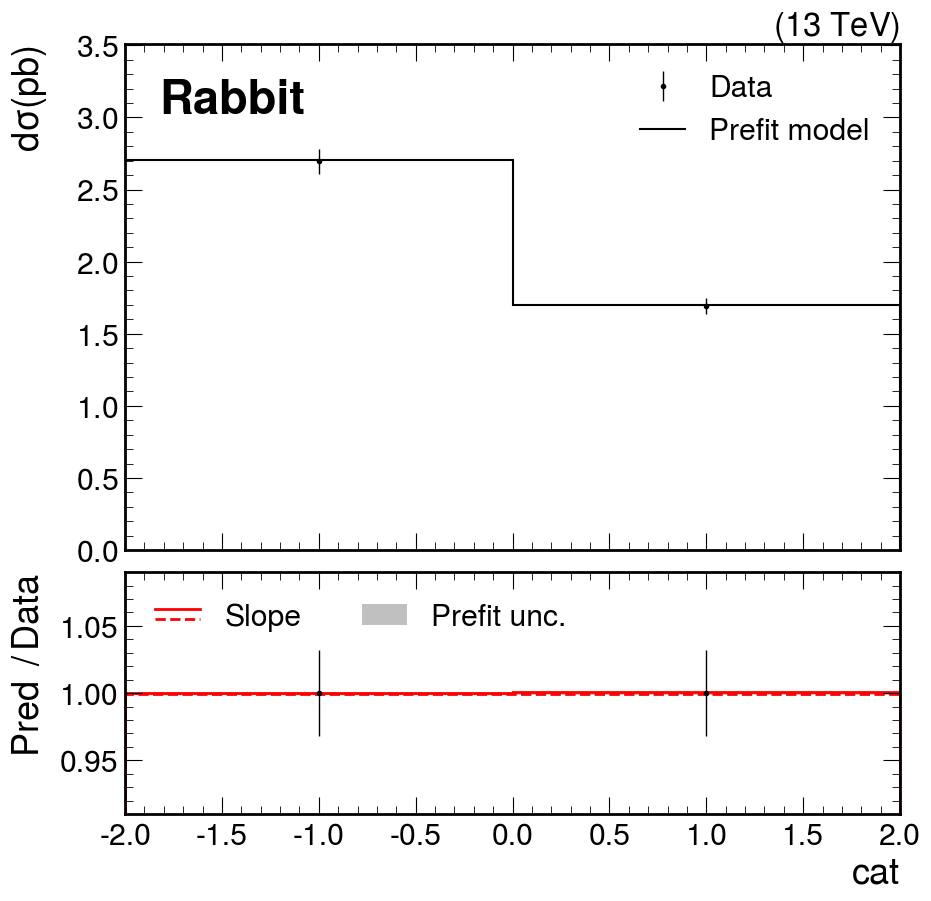

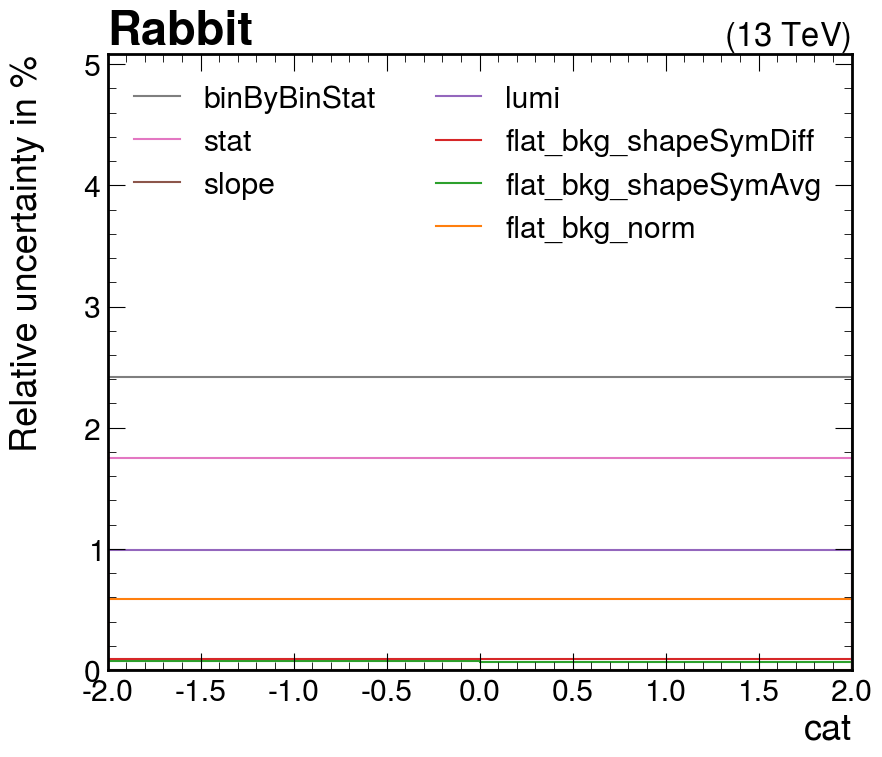

In [14]:
!rabbit_plot_hists.py results/advanced/fitresults_linear.hdf5 -m Select -o ./results/advanced \
 --legCols 1 --rrange 0.91 1.09 --ratioToData --yscale 1.2 --unfoldedXsec \
--varName slope --varLabel 'Slope' --varColor red

!rabbit_plot_hists_uncertainties.py results/advanced/fitresults.hdf5 -m Select -o ./results/advanced \
--yscale 2 --titlePos 0

display(Image(filename='results/advanced/postfit_cat_ch0_masked_Select.png'))
display(Image(filename='results/advanced/uncertainties_cat_ch0_masked_Select.png'))

### Pulls and impacts

In [15]:
!rabbit_plot_pulls_and_impacts.py results/advanced/fitresults_nonlinear.hdf5 -o ./results/advanced \
--globalImpacts -m Ratio --postfix ratio --impactTitle 'Ratio [.%]' \
--showNumbers --oneSidedImpacts --scaleImpacts 1000\
--referenceFile results/advanced/fitresults_linear.hdf5 --name 'Nonlinear' --refName 'Linear'

IFrame(src='results/advanced/global_impacts_grouped_yield0_ratio.html', width='100%', height=300)

INFO:rabbit_plot_pulls_and_impacts.py: Found mapping Ratio ch0_masked ch0_masked cat:0 cat:1 with channels ['ch0_masked']
Now at {'yield': np.int64(0)}
Write output file ./results/advanced/pulls_and_global_impacts_yield0_ratio.html
Now at {'yield': np.int64(0)}
Write output file ./results/advanced/global_impacts_grouped_yield0_ratio.html


## Custom mappings

We want to define our own custom mapping. Any differentiable function can be implemented. 

For whatever reason we want to know what is $f(x,y) = x \cdot \sin^2(x/y)$ where $x$ is the bin in cat0 and $y$ is the bin in cat1. A custom model needs to implement:
* the `__init__` function which is called once at the beginning,
* a `parse_args` function to define how the command line option is to be interpreted,
* the `compute` functions which is evaluated to compute the prefit and postfit expectation and uncertainties.

We notice that the model is actually pretty similar to the ratio model, it has two terms and does some transformation on them. So we can use that one as a starting point and don't need to implement out own parsing function.

In [16]:
%%writefile ../tests/my_custom_mapping.py

# write the following to a file
import tensorflow as tf

from rabbit.mappings import helpers
from rabbit.mappings.ratio import Ratio

class Custom(Ratio):
    def __init__(
        self,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)

    def compute_flat(self, params, observables):
        x = self.num.select(observables, inclusive=True)
        y = self.den.select(observables, inclusive=True)

        r = tf.reshape(x / y, [-1])
        
        result = x * tf.square(tf.sin(r))
        return result

Overwriting ../tests/my_custom_mapping.py


Now let's evaluate this new mapping. Subsequently we can treat it as any other channel, e.g. look at the uncertainty breakdown.

Since this doesn't change anything on the fit we can use the previous fitresult to avoid minimizing the likelihood again.

In [17]:
!rabbit_fit.py ./results/advanced/input.hdf5 -t 0 --unblind -o ./results/advanced \
-m tests.my_custom_mapping.Custom ch0_masked ch0_masked cat:0 cat:1 --postfix custom_mapping \
--externalPostfit ./results/advanced/fitresults.hdf5 \
--saveHists --saveHistsPerProcess --computeHistErrors --computeHistCov --computeVariations --computeHistImpacts

2026-02-27 18:24:43.474660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:24:43.475005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:24:43.526523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:24:44.891990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [18]:
!rabbit_plot_pulls_and_impacts.py results/advanced/fitresults_custom_mapping.hdf5 -o ./results/advanced \
--globalImpacts -m Custom --impactTitle 'x sin<sup>2</sup>(x/y)' \
--showNumbers --oneSidedImpacts --postfix custom

IFrame(src='results/advanced/global_impacts_grouped_yield0_custom.html', width='100%', height=300)

INFO:rabbit_plot_pulls_and_impacts.py: Found mapping Custom ch0_masked ch0_masked cat:0 cat:1 with channels ['ch0_masked']
Now at {'yield': np.int64(0)}
Write output file ./results/advanced/pulls_and_global_impacts_yield0_custom.html
Now at {'yield': np.int64(0)}
Write output file ./results/advanced/global_impacts_grouped_yield0_custom.html


## POI Models

A reparameterization of the likelihood can be achieved using POI models. A poi model is a function that takes the parameter of interest (POIs), $\vec{\mu}$ and computes a tensor that gets multiplied to the number of predicted events by bin and process.

The default POI model is the `Mu` model which just scales signal processes with $\mu$ and multiplies 1 to background processes. The `Ones` model multiplies all processes with 1. The `Mixture` model multiplies one signal process with $\mu$ and another one with $1-\mu$. 

POI models can also be used to generate shape variations in the bin dimension.

Let's produce our own POI model, we want to multiply one bin in the category axis with $\sin^2(\mu)$ and the other one with $\cos^2(\mu)$. The way to implemented is very similar to the mappings.
A model has an `__init__` function that is executed in the beginning and an `compute` function which is executed every time the likelihood is evaluated.


In [19]:
%%writefile ../tests/my_custom_model.py 

# write the following to a file
import tensorflow as tf
import numpy as np
import hist

from rabbit.poi_models.poi_model import POIModel

class Custom(POIModel):

    def __init__(self, indata, expectSignal=None, allowNegativePOI=False, **kwargs):
        self.indata = indata

        self.npoi = self.indata.nsignals

        self.pois = np.array([s for s in self.indata.signals])

        self.allowNegativePOI = allowNegativePOI

        self.is_linear = self.npoi == 0 or self.allowNegativePOI

        self.set_poi_default(expectSignal, self.allowNegativePOI)
        
        # we have to keep track which bins are cat:0 and which ones are cat:1
        #  we follow the same logic as used when the bin array is constructed and set 0 or 1 based on the "cat" bin
        flat_values = []
        flat_values_masked = []
        for i, c in indata.channel_info.items():
            hi = hist.Hist(*c["axes"])
            
            if len(hi.axes) == 1:
                hi.values()[...] = np.array([0,1])
            else:
                hi[{"cat":0}].values()[...] = 0
                hi[{"cat":1}].values()[...] = 1
                
            if c["masked"]:
                flat_values_masked.append(hi.values().flatten().astype("float64"))
            else:
                flat_values.append(hi.values().flatten().astype("float64"))
            
        self.is_cat1 = tf.concat(flat_values, axis=0)
        self.is_cat1_full = tf.concat([*flat_values, *flat_values_masked], axis=0)
        
    def compute(self, poi, full=False):
        if full:
            nbins = self.indata.nbinsfull
            is_cat1 = self.is_cat1_full
        else:
            nbins = self.indata.nbins
            is_cat1 = self.is_cat1
            
        signal_slice = (1 - is_cat1) * tf.square(tf.sin(poi)) + is_cat1 * tf.square(tf.cos(poi))
        signal_slice = tf.reshape(signal_slice, [1, -1])
        bkg_slice = tf.ones([self.indata.nproc - poi.shape[0], nbins], dtype=self.indata.dtype)
        
        rnorm = tf.concat(
            [signal_slice, bkg_slice],
            axis=0,
        )
        
        
        rnorm = tf.transpose(rnorm)

        return rnorm

Overwriting ../tests/my_custom_model.py


In [26]:
!rabbit_fit.py ./results/advanced/input.hdf5 -t 0 --unblind -o ./results/advanced \
--poiModel tests.my_custom_model.Custom --postfix custom_model \
--doImpacts --globalImpacts

2026-02-27 18:28:38.263050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-27 18:28:38.263420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 18:28:38.312556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 18:28:39.716507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [34]:
!rabbit_print_pulls_and_constraints.py results/advanced/fitresults_custom_model.hdf5

   Parameter                        pull +/- constraint (pull prefit +/- constraint prefit)
   ----------------------------------------------------------------------------------------------------
   signal                         1.22521 +/-    0.09383 (        1.0 +/-               0.0)
   slope                          0.26962 +/-    0.73037 (        0.0 +/-               0.0)
   flat_bkg_norm                  -0.51407 +/-    0.61778 (        0.0 +/-               1.0)
   flat_bkg_shapeSymAvg           -0.07825 +/-    0.35522 (        0.0 +/-               1.0)
   flat_bkg_shapeSymDiff          0.19305 +/-    0.97924 (        0.0 +/-               1.0)
   lumi                              0.0 +/-        1.0 (        0.0 +/-               1.0)


In [32]:
!rabbit_plot_pulls_and_impacts.py results/advanced/fitresults_custom_model.hdf5 -o ./results/advanced \
--globalImpacts --impactTitle 'POI' --referenceFile results/advanced/fitresults.hdf5 \
--showNumbers --oneSidedImpacts --postfix custom

IFrame(src='results/advanced/pulls_and_global_impacts_signal_custom.html', width='100%', height=300)

Now at signal
Write output file ./results/advanced/pulls_and_global_impacts_signal_custom.html
Write output file ./results/advanced/global_impacts_grouped_signal_custom.html
